In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

sns.set(color_codes = True)
pd.set_option('display.max_columns', 100)

import warnings

# Ignore all warnings 
warnings.filterwarnings("ignore")

## Context
- [Package Import and Data Loading](#1)
- [Feature Engineering](#2)
- [Variable Correlation](#3)
- [Removing Outliers](#4)
- [Building Model]

# Loading Data

In [5]:
client_data = pd.read_csv('client_data.csv')
price_data = pd.read_csv('price_data.csv')

In [7]:
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
2,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
3,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
4,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0


In [9]:
# Renaming columns
client_data = client_data.rename(columns={'forecast_price_energy_p1': 'forecast_price_energy_off_peak', 
                                          'forecast_price_energy_p2': 'forecast_price_energy_peak', 
                                          'forecast_price_pow_p1': 'forecast_price_pow_off_peak'})


In [11]:
client_data.head(2)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.3,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1


In [13]:
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [15]:
#convert to a datetime format

price_data['price_date'] = pd.to_datetime(price_data['price_date'], format='%Y-%m-%d')

In [17]:
price_data.head(2)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0


### 2. Feature engineering

#### Difference between off-peak prices in December and preceding January

Analyzing price changes, such as the differences between off-peak energy and power prices from December to January, can be quite relevant for understanding customer churn rates for reasons such as;

- Price sensitivity; significant price increases may make customers reconsider their loyalty to a provider. Analyzing how price changes correlate with churn can identify if higher costs lead to increased cancellations.
- Predictive Analytics; By incorporating price changes into predictive models, we can better forecast churn. If price fluctuations are statistically linked to churn events, we can use this information to proactively engage at-risk customers.

In [20]:
#calculating the difference between December and January prices for price_off_peak_var and price_off_peak_fix.

# Group off-peak prices by Id and month
monthly_price_by_id = price_data.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()


In [22]:
# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference

#Merging December and January Prices
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
#calculate the differences between December and January for both energy and power prices 
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
#flter the DataFrame to keep only id and the newly calculated difference columns
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [24]:
#merging newly calculated columns to our client dataset using Id
client_data = pd.merge(client_data, diff, on='id')
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0,-0.007952,0.236694
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961
2,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779
3,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779
4,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779


### Average price changes across periods
We can enhance the above feature by calculating the average price changes across individual periods, instead of the entire year.

In [28]:
# Aggregate average prices per period by Id
mean_prices = price_data.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [30]:

#calculates the mean differences between various price categories in the mean_prices DataFrame. 
#This analysis can provide insights into how different pricing structures relate to each other
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']


In [32]:
#merging new columns to the client_data using column ID

columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
client_data = pd.merge(client_data, mean_prices[columns], on='id')
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0,-0.007952,0.236694,0.011334,0.024874,0.036208,22.599614,28.019836,50.619451
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
2,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
3,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
4,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265


This feature (Average price changes) may be useful because as it adds a level of detail to the existing feature. Instead of looking at differences across an entire year, we have now created features that also look at mean average price differences across different time periods (off_peak, peak, mid_peak). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.

#### Max price changes across periods and months
Another way we can enhance the feature from our colleague is to look at the maximum change in prices across periods and months.



In [37]:
# Aggregate average prices per period by company
mean_prices_by_month = price_data.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [39]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']


In [41]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [43]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

client_data = pd.merge(client_data, max_diff_across_periods_months[columns], on='id')
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,2012-11-07,2016-11-06,2012-11-07,2015-11-09,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0,-0.007952,0.236694,0.011334,0.024874,0.036208,22.599614,28.019836,50.619451,0.012569,0.026096,0.038665,22.682779,28.122958,50.805737
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930
2,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.444710
3,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.444710
4,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.444710


### Further Feature Engineering
In the previous notebook, we explore the data and made a deep dive into the churn by dates. Nonetheless, that exploration was quite shallow and did not provide us with any relevant insight.

#### Tenure
What if we could create a new variable that could provide us more relevant insights?

We will define a variable  tenure = date_end - date_activ

Tenure 
How long a company has been a client.

In [48]:
# Convert columns to datetime
client_data['date_activ'] = pd.to_datetime(client_data['date_activ'])
client_data['date_end'] = pd.to_datetime(client_data['date_end'])

In [50]:
# Calculate tenure in years
client_data['tenure'] = (client_data['date_end'] - client_data['date_activ']).dt.days / 365.25

In [52]:
#convert to integer if you only want whole years
client_data['tenure'] = client_data['tenure'].astype(int)

In [54]:
#Grouping and Counting clients based on tenure and churn, to analyze relationship between tenure and churn rates.
tenure = client_data[['id', 'tenure', 'churn']].groupby(['tenure', 'churn'])['id'].count().unstack(level = 1).fillna(0)
#calculating percentages
tenure_percentage = (tenure.div(tenure.sum(axis = 1), axis = 0)* 100)

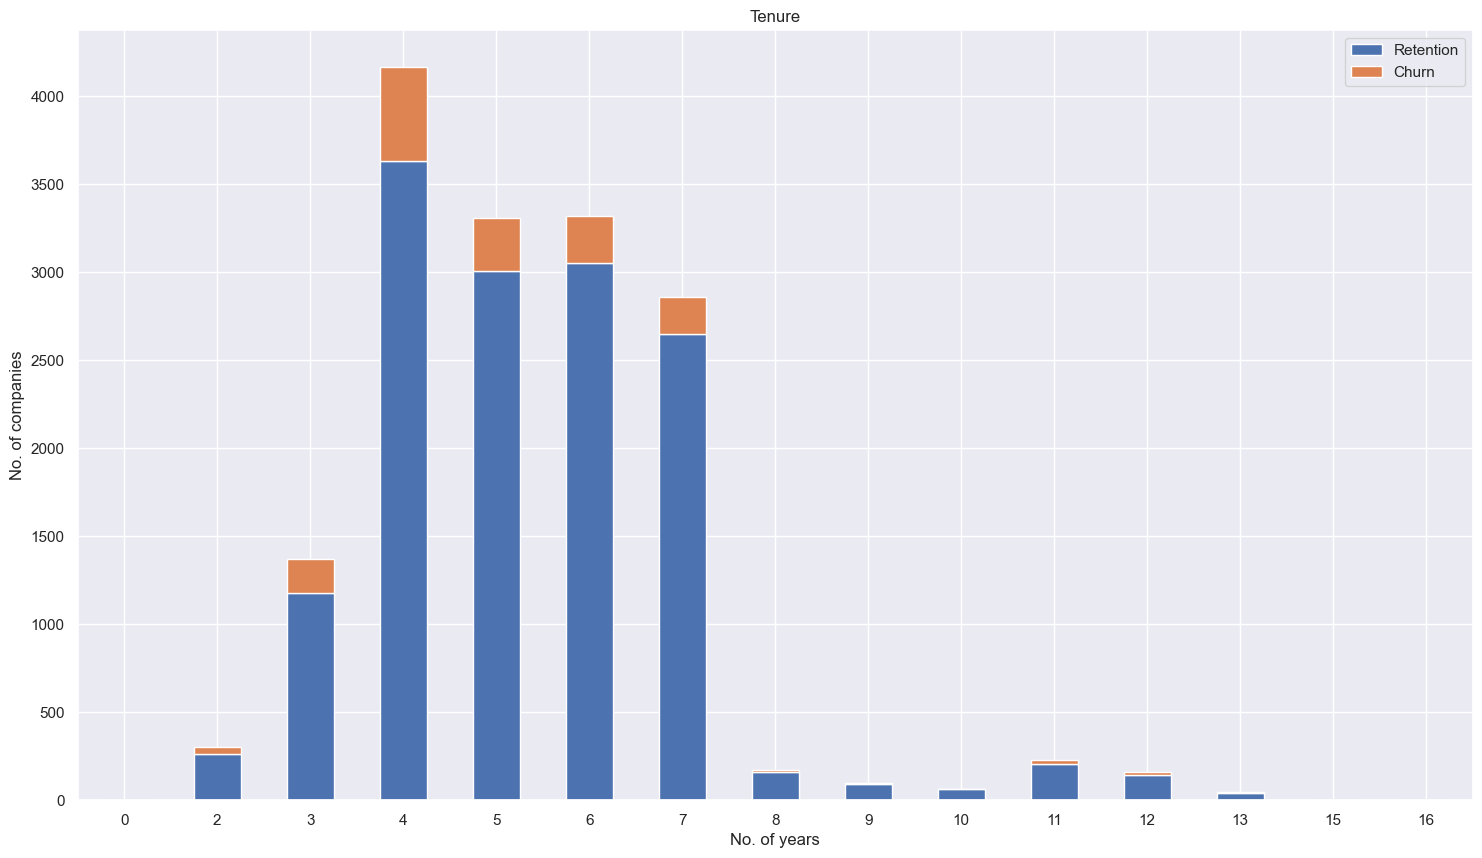

In [56]:
tenure.plot(kind = 'bar', 
            figsize = (18, 10),
            stacked = True,
            rot = 0,
            title = 'Tenure');
plt.legend(['Retention', 'Churn'], loc = 'upper right')
plt.ylabel('No. of companies')
plt.xlabel('No. of years')
plt.show();

We can see that there is a higher churn rate wth companies within the 3 - 7 year tenure, while companies who just joined or have a longer contract (longer than 7 years) are less likely to churn.

This is an interesting feature to keep for modelling because clearly how long you've been a client, has a impact on the chance of a client churning.

#### Transforming the dates provided into months so that we can make more sense out of those.

    months_activ: Number of months active until reference date (Jan 2016)

    months_to_end: Number of months of the contact left at reference date (Jan 2016)

    months_modif_prod: Number of months since last modification at reference date (Jan 2016)

    months_renewal: Number of months since last renewal at reference date (Jan 2016)

To create the month column we will follow a simple process:

    Substract the reference date and the column date
    Convert the timedelta in months
    Convert to interger (we are not interested in having decimal months)

In [60]:


# Convert date columns in client_data to datetime
client_data['date_activ'] = pd.to_datetime(client_data['date_activ'], errors='coerce')
client_data['date_end'] = pd.to_datetime(client_data['date_end'], errors='coerce')
client_data['date_modif_prod'] = pd.to_datetime(client_data['date_modif_prod'], errors='coerce')
client_data['date_renewal'] = pd.to_datetime(client_data['date_renewal'], errors='coerce')


In [62]:
def convert_months(reference_date, client_data, column):
    """
    Input a column with dates and return the number of months from the reference date.
    """
    time_delta = reference_date - client_data[column]
    # Convert to days, then to months
    months = (time_delta / np.timedelta64(1, 'D')) / 30.44  # Average days in a month
    return months.astype(int)

# Create reference date
reference_date = datetime(2016, 1, 1)

# Create new columns based on the number of months from the reference date (January 1, 2016) to specified date columns
client_data['months_activ'] = convert_months(reference_date, client_data, 'date_activ')
#calculates how many months until each date_end from the reference date, negating the value to represent it as a positive count
client_data['months_to_end'] = -convert_months(reference_date, client_data, 'date_end')
client_data['months_modif_prod'] = convert_months(reference_date, client_data, 'date_modif_prod')
client_data['months_renewal'] = convert_months(reference_date, client_data, 'date_renewal')


In [64]:
import matplotlib.pyplot as plt

def plot_churn_by_month(client_data, column, fontsize_=11, rot_=0):
    '''
    Plot churn distribution by monthly variable.
    
    Parameters:
        client_data (DataFrame): The DataFrame containing client information.
        column (str): The column name for the monthly variable.
        fontsize_ (int): Font size for x-tick labels.
        rot_ (int): Rotation angle for x-tick labels.
    '''
    # Check if the specified column exists in the DataFrame
    if column not in client_data.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
    
    # Group by the specified column and churn status
    temp = client_data[[column, 'churn', 'id']].groupby([column, 'churn'])['id'].count().unstack(level=1)

    # Plotting
    temp.plot(kind='bar',
               figsize=(30, 15),
               stacked=True,
               rot=rot_,
               title=f'Churn Distribution by {column}')
    
    # Rename legend
    plt.legend(['Retention', 'Churn'], loc='upper right')
    
    # Labels
    plt.ylabel('Number of Companies')
    plt.xlabel(column)
    plt.xticks(fontsize=fontsize_)
    plt.title(f'Churn Distribution by {column}', fontsize=fontsize_ + 2)
    
    plt.show();

# Example usage
# plot_churn_by_month(client_data, 'months_activ')


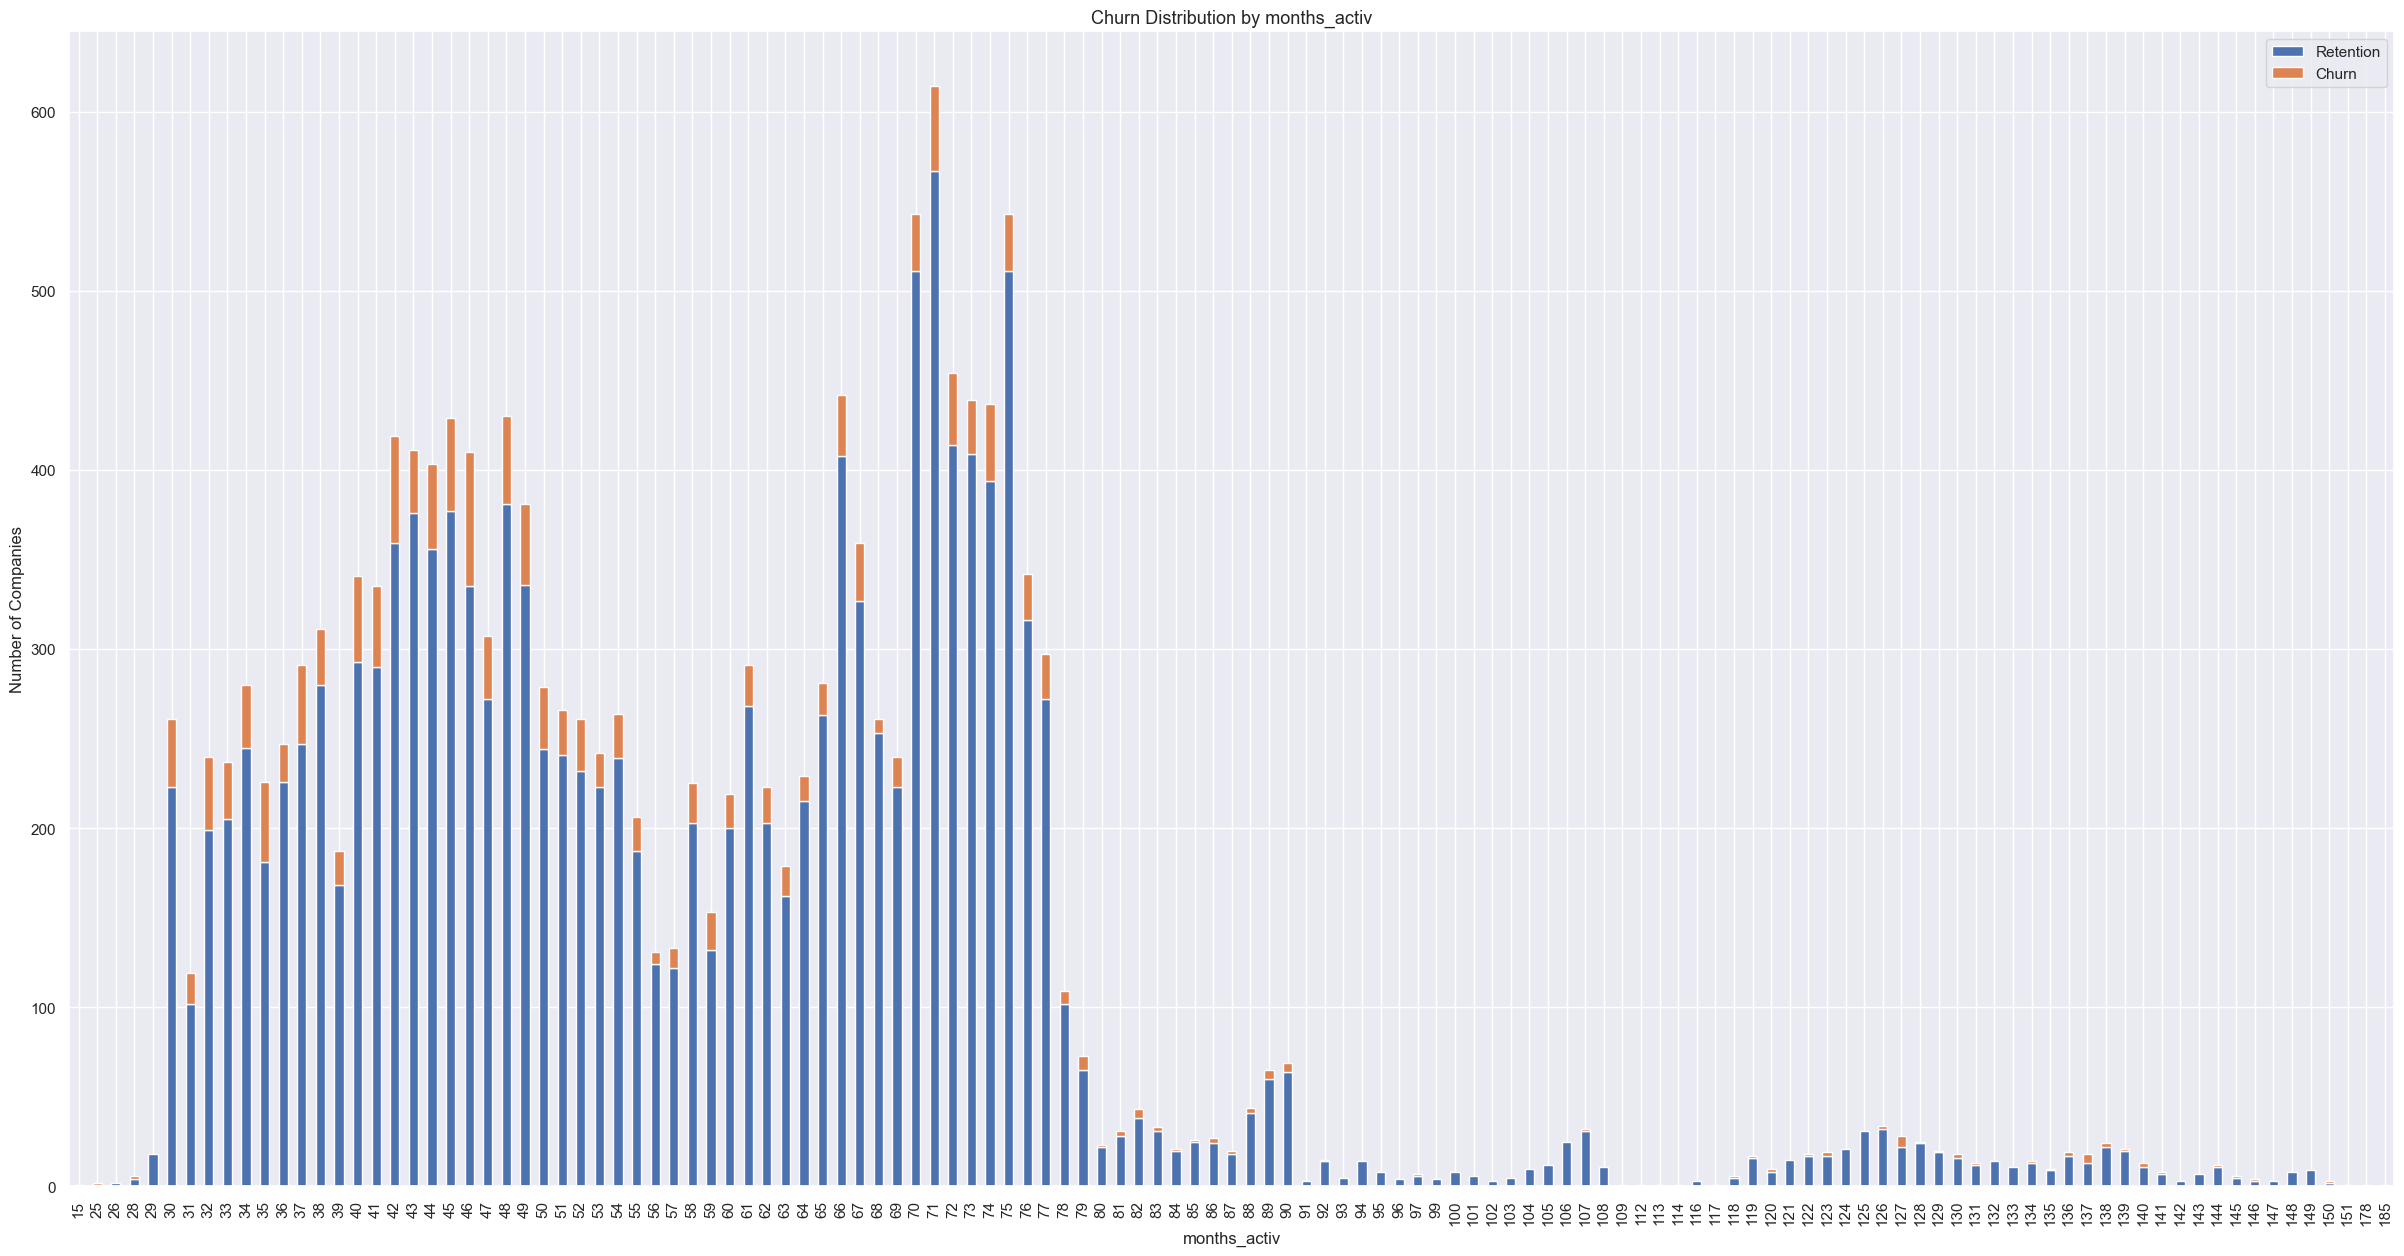

In [66]:
plot_churn_by_month(client_data, 'months_activ', rot_ = 90)

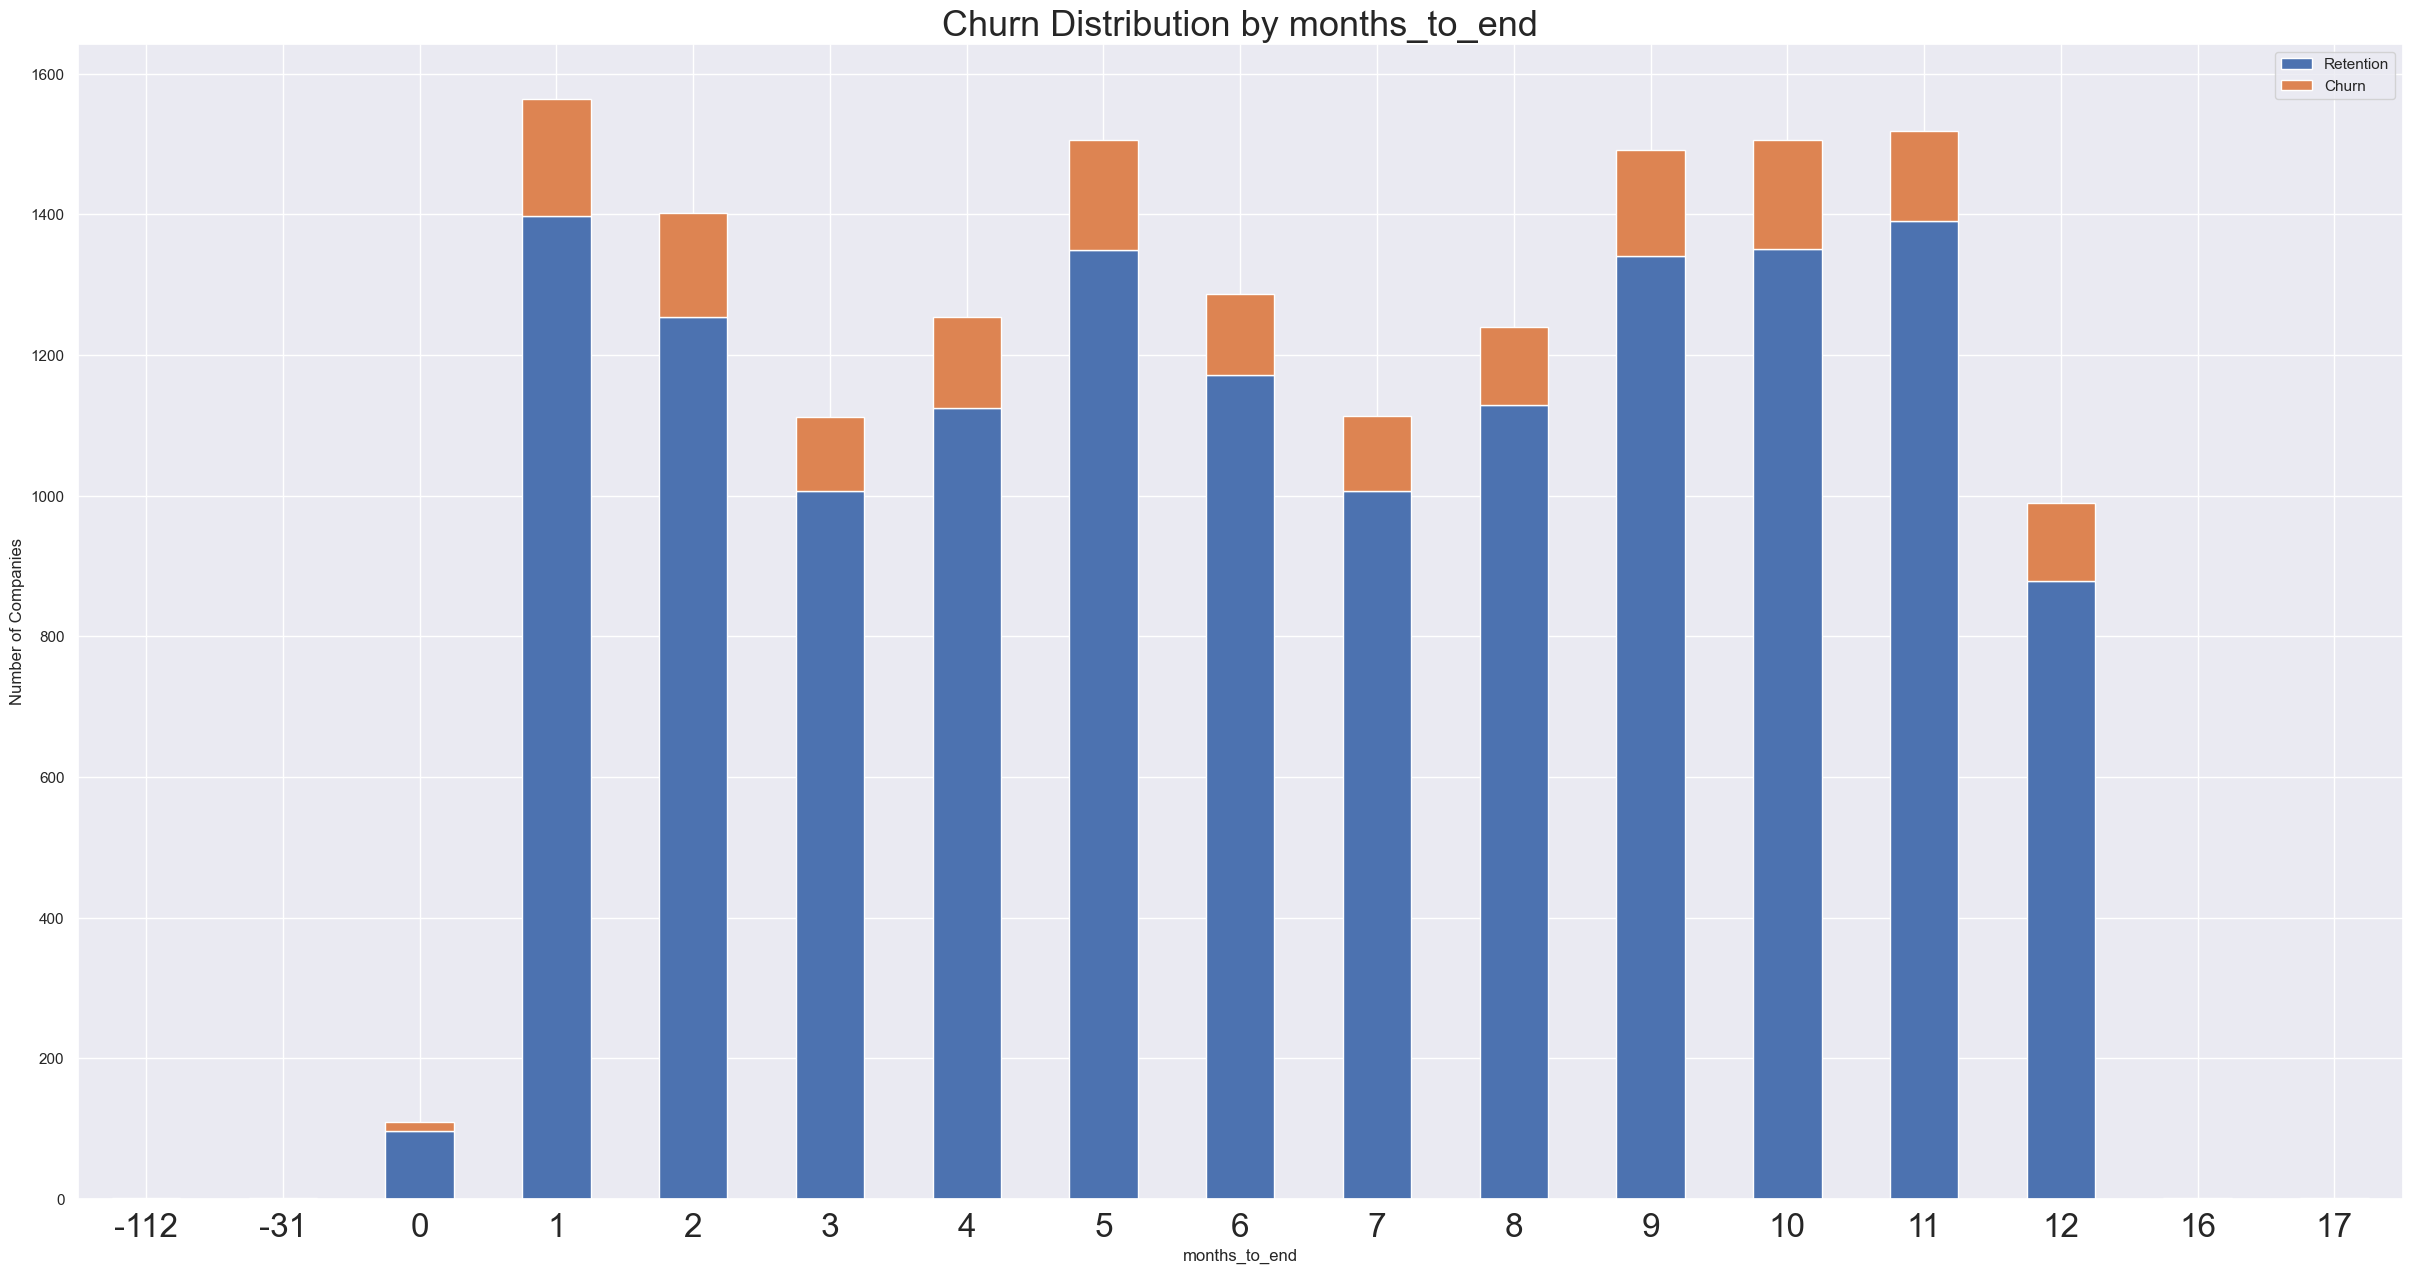

In [68]:
plot_churn_by_month(client_data, 'months_to_end', 24)

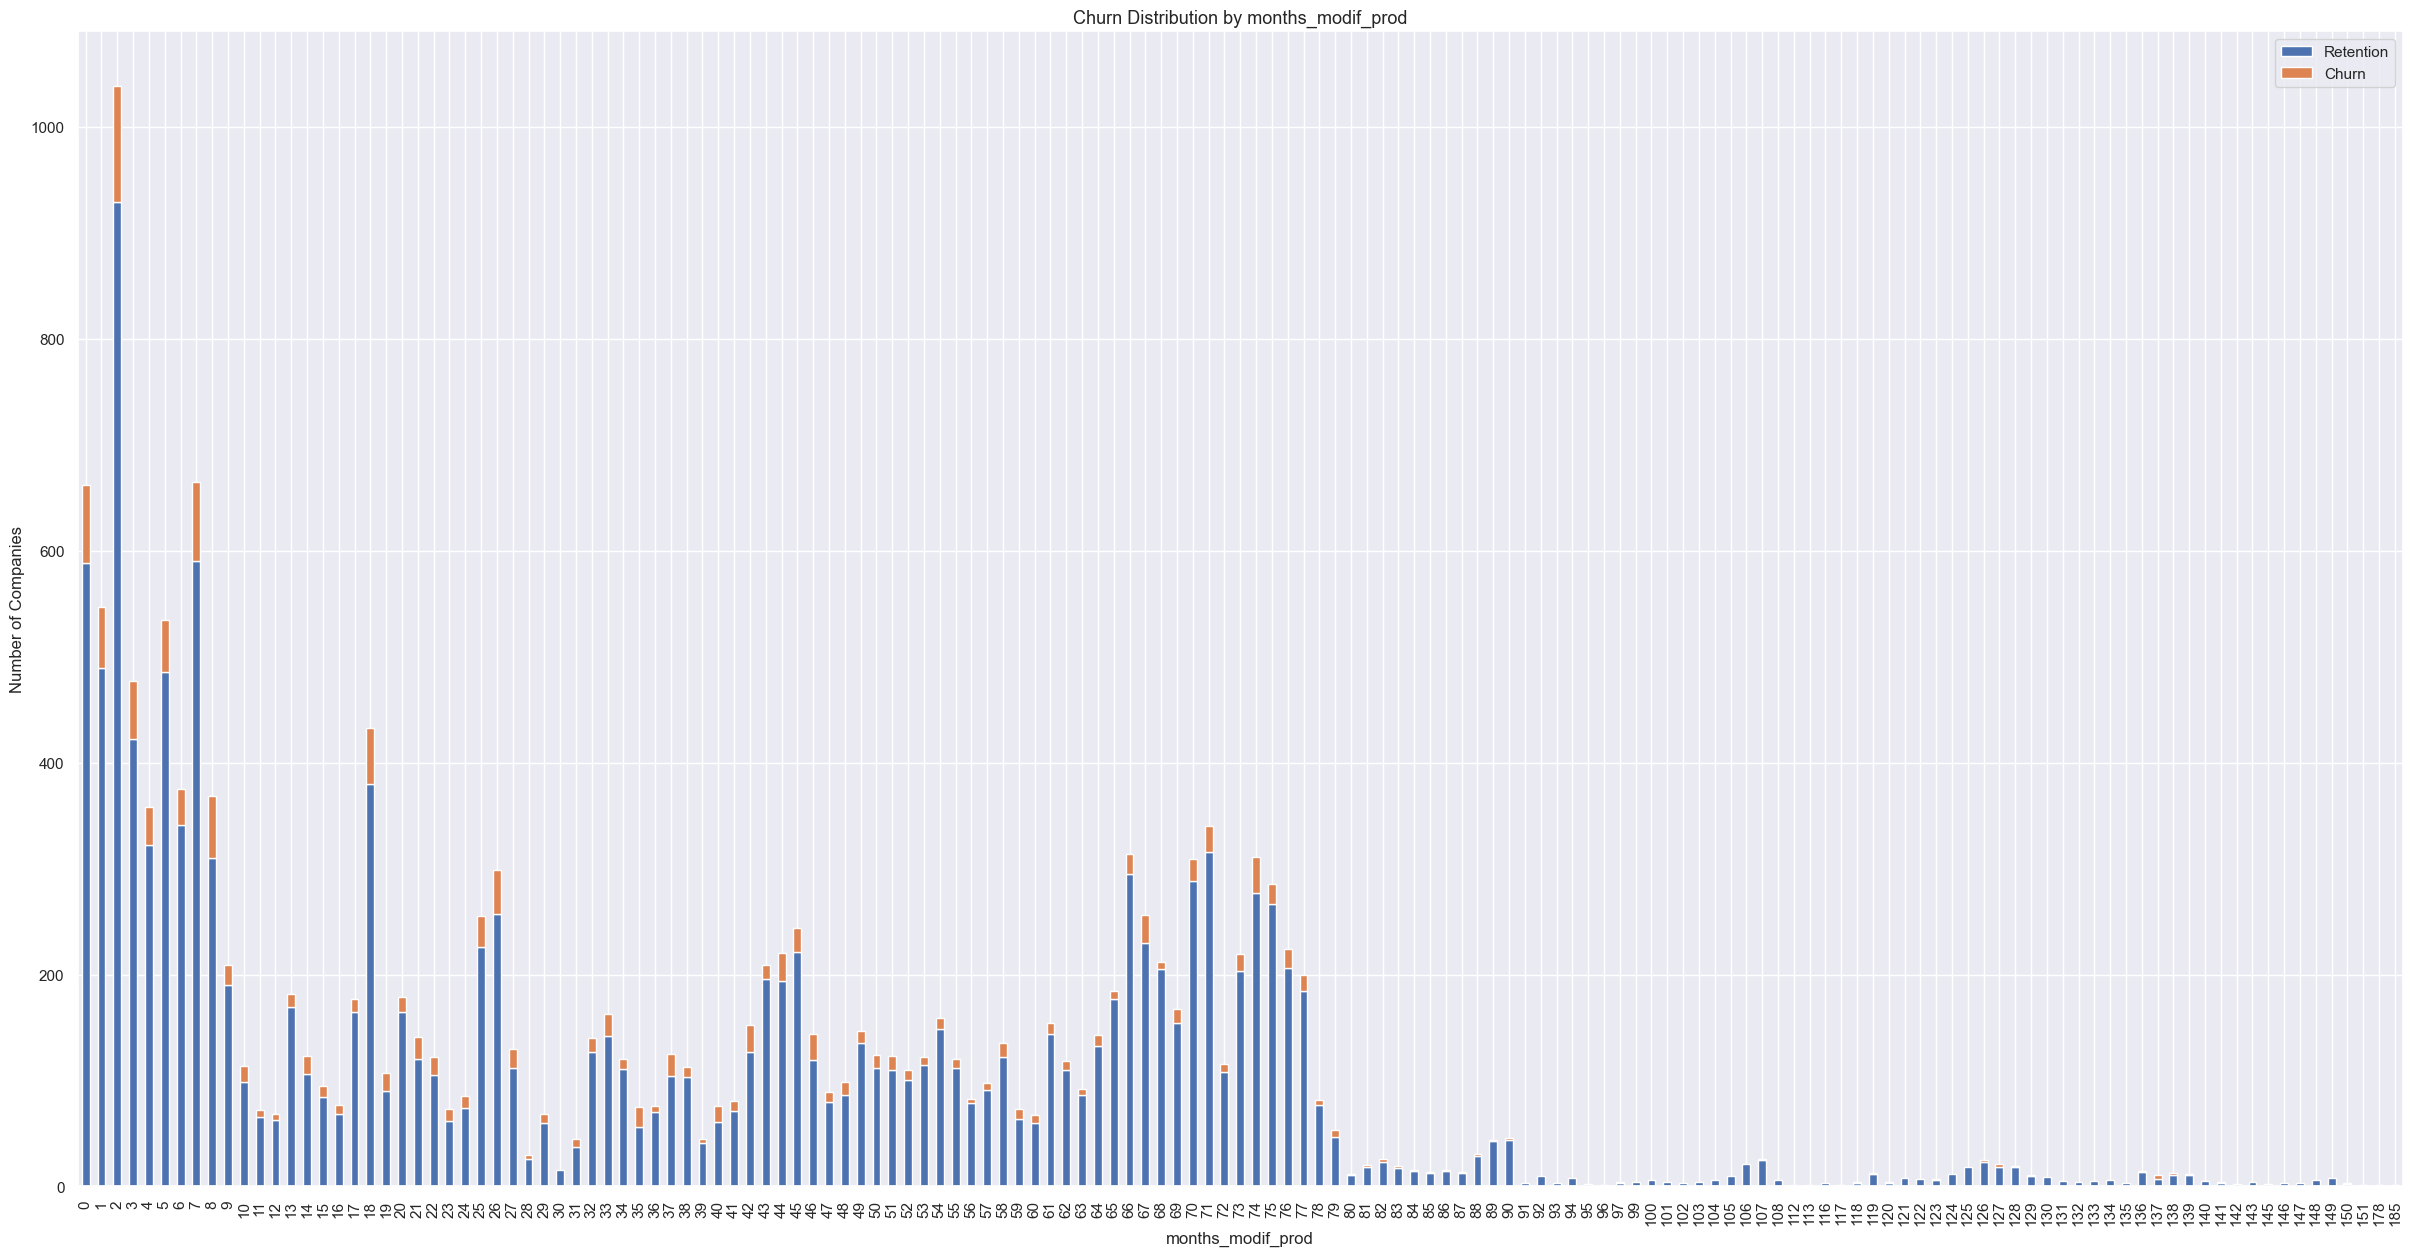

In [70]:
plot_churn_by_month(client_data, 'months_modif_prod', rot_ = 90)

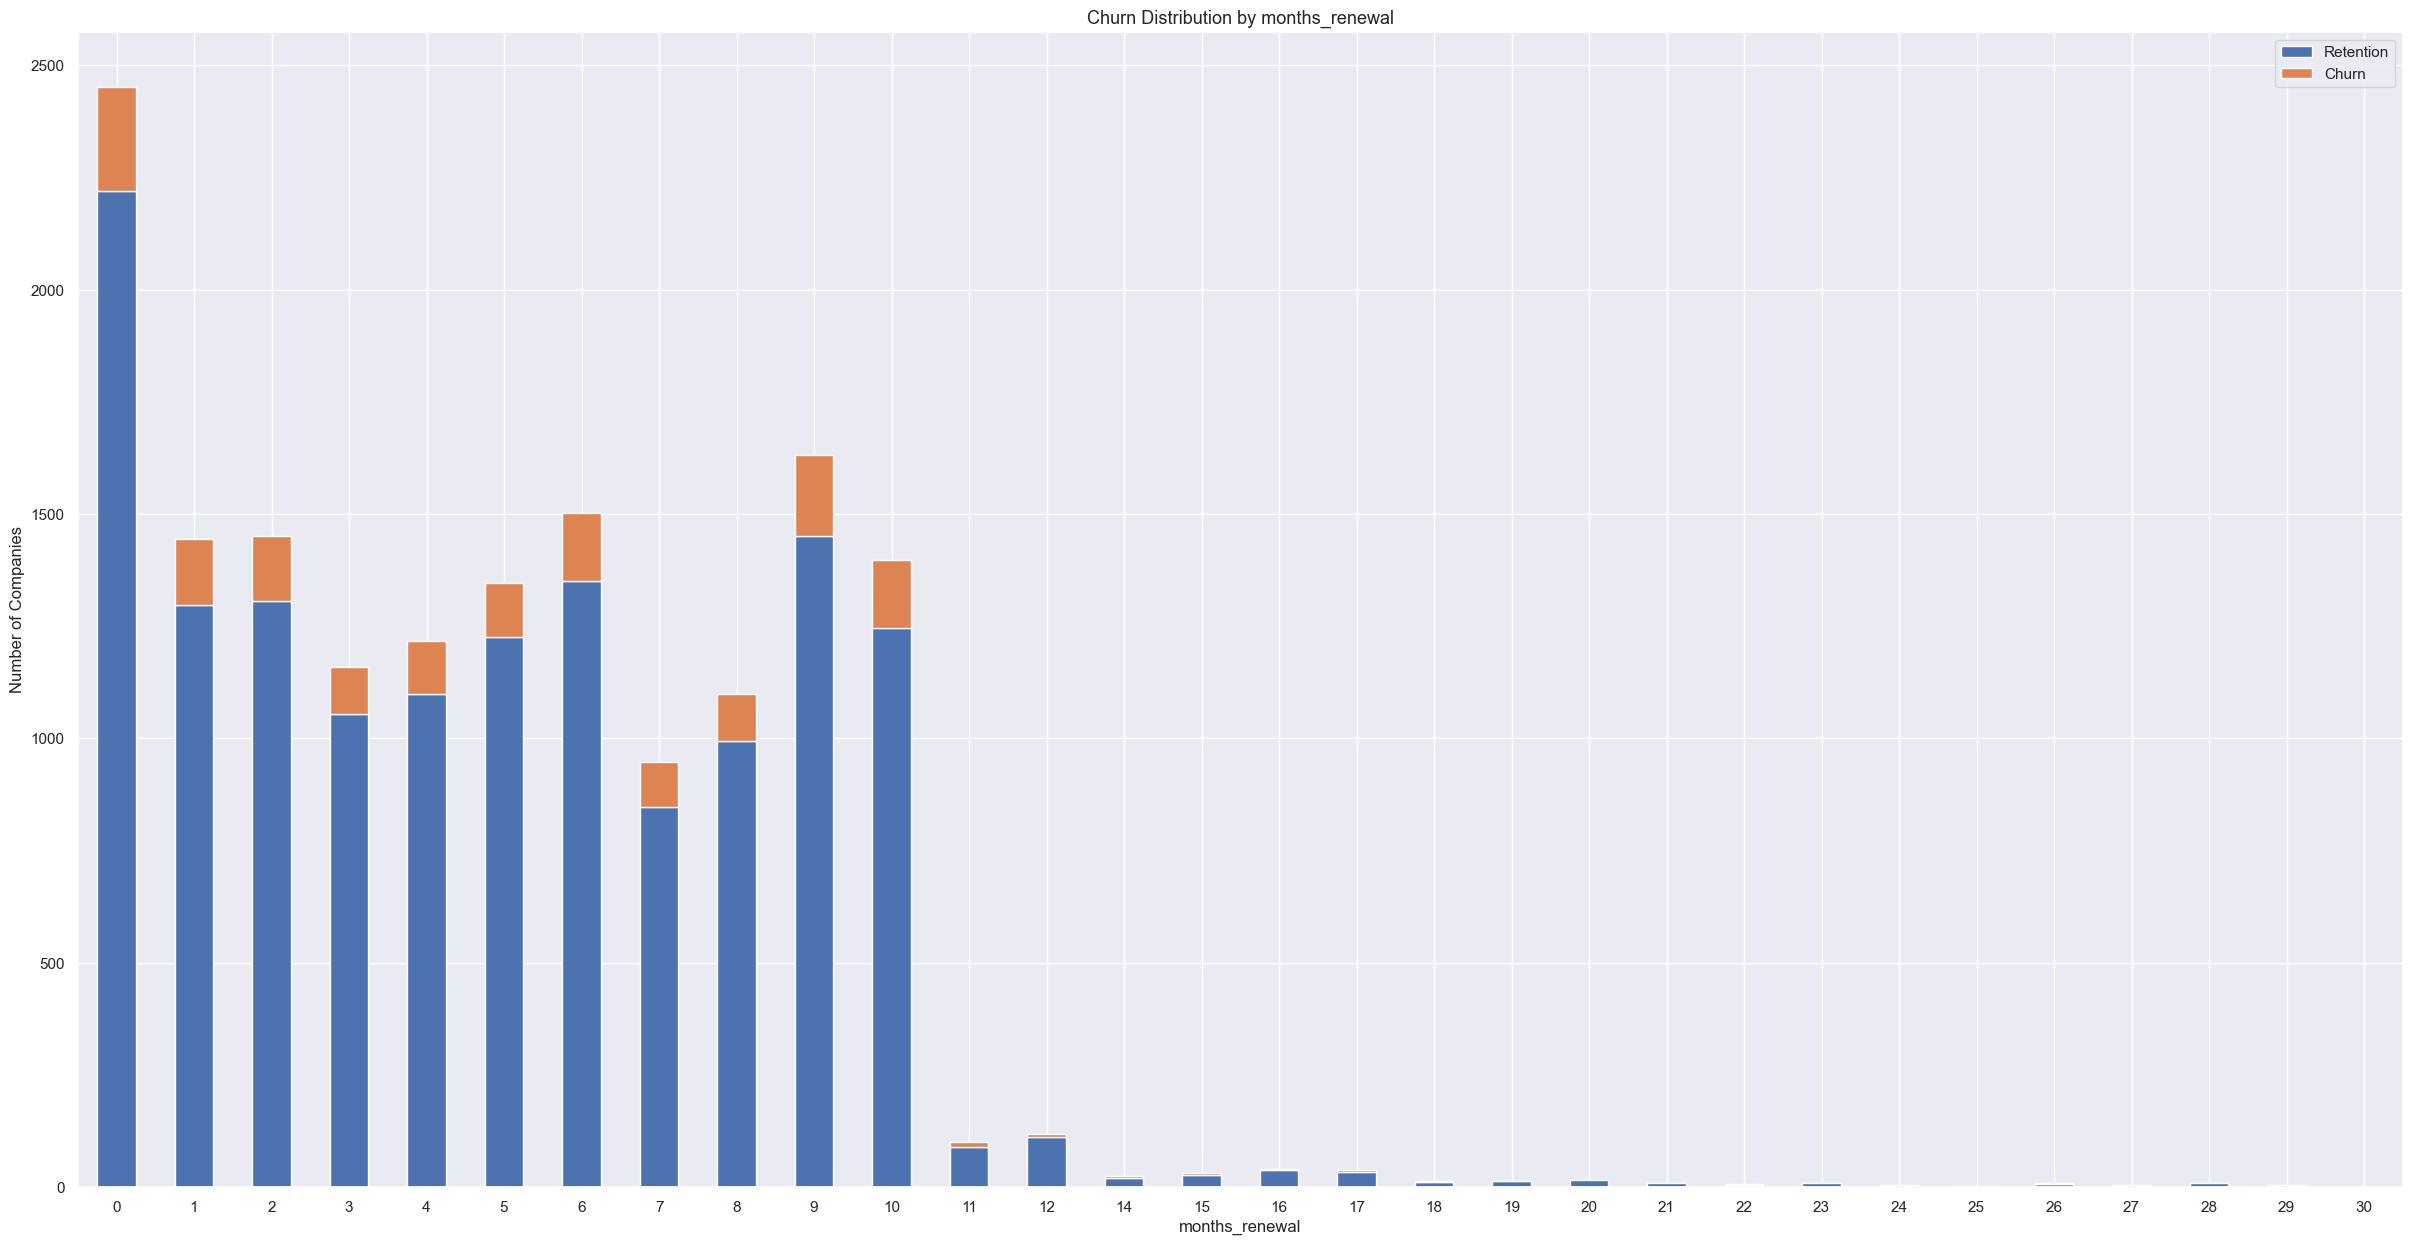

In [72]:
plot_churn_by_month(client_data, 'months_renewal')

#### Observations
Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes to create some other features that may hold some predictive power.

We could assume that a company who has been an active client for a longer amount of time may have more loyalty to the brand and is more likely to stay. Whereas a newer client may be more volatile. Hence the addition of the months_activ feature.

If a client is approaching the end of their contract a number options are available. The client may seek out better deals for when their contract ends, or they might want to see out their contract and sign another one. One the other hand, if they're in the middle of their contract, there may be charges if they intend to leave before the contract ends, hence deterring clients from churning mid-way through their agreement. We believe months_to_end will be an interesting feature because it may reveal patterns and behaviours about timing of churn.

If a client makes recent updates to their contract, they are more likely to be satisfied or at least they have received a level of customer service to update or change their existing services. This is a positive sign which shows they are an engaged customer,hence months_modif_prod will also be an interesting feature to include because it shows the degree of how 'engaged' a client is.

Finally, the number of months since a client last renewed a contract is another interesting feature because, again, it shows the degree to which that client is engaged. It also goes a step further than just engagement, it shows a level of commitment if a client renews their contract. For this reason,we believe months_renewal will be a good feature to include.

In [76]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them

client_data = client_data.drop(columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])
client_data.head(2)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,26520.3,10025,0.0,359.29,0.095919,0.088347,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0,-0.007952,0.236694,0.011334,0.024874,0.036208,22.599614,28.019836,50.619451,0.012569,0.026096,0.038665,22.682779,28.122958,50.805737,3,37,10,37,1
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930,3,30,5,2,6


#### Transforming Boolean data
##### has_gas
We simply want to transform this column from being categorical to being a binary flag
We will replace t for True or 1, and f for False or 0. This process is usually referred as onehot encoding

In [80]:
client_data['has_gas'] = client_data['has_gas'].replace(['t', 'f'], [1, 0])

#calculates the mean churn rate based on whether clients have gas or not
client_data.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.103640
1,0.078947


This indicates that, on average, 10% of clients without gas churned, while only 7% of clients with gas churned. Hence, this is a useful feature.

### Transforming categorical data
A predictive model cannot accept categorical or string values, as such we need to encode categorical features into numerical representations in the most compact way possible.

The simplest method is to map each category to an integer (label encoding), however this is not always appropriate beecause it then introduces the concept of an order into a feature which may not inherently be present 0 < 1 < 2 < 3 ...

Another way to encode categorical features is to use dummy variables AKA one hot encoding. This creates a new feature for every unique value of a categorical column, and fills this column with either a 1 or a 0 to indicate that this company does or does not belong to this category.

- channel_sales
- origin_up

#### channel_sales

In [86]:
# Transform into categorical type
client_data['channel_sales'] = client_data['channel_sales'].astype('category')

# Let's see how many categories are within this column
client_data['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    7377
MISSING                             4218
lmkebamcaaclubfxadlmueccxoimlema    2073
usilxuppasemubllopkaafesmlibmsdf    1444
ewpakwlliwisiwduibdlfmalxowmwpci     966
sddiedcslfslkckwlfkdpoeeailfpeds      12
epumfxlbckeskwekxbiuasklxalciiuu       4
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

We have 8 categories, so we will create 8 dummy variables from this column. However, as you can see the last 3 categories show that they only have 12, 4 and 2 occurrences respectively. Considering that our dataset has about 14000 rows, this means that these dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all (since they're almost entirely a constant value and provide very little).

For this reason, we will drop these 3 dummy variables.

In [89]:
# create dummy variables
client_data = pd.get_dummies(client_data, columns=['channel_sales'], prefix='channel')


In [91]:
# Convert dummy columns to 1/0 ijstead of true/false
dummy_columns = [col for col in client_data.columns if col.startswith('channel_')]
client_data[dummy_columns] = client_data[dummy_columns].astype(int)

In [93]:
#dropping last 3 categories
client_data = client_data.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])


In [95]:
client_data.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,48ada52261e7cf58715202705a0451c9,309275,0,10025,26520.30,10025,0.0,359.29,0.095919,0.088347,58.995952,0,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000,0,-0.007952,0.236694,0.011334,0.024874,0.036208,22.599614,28.019836,50.619451,0.012569,0.026096,0.038665,22.682779,28.122958,50.805737,3,37,10,37,1,0,0,0,1,0
1,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930,3,30,5,2,6,0,0,1,0,0
2,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,0,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.444710,7,76,7,76,4,1,0,0,0,0
3,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,0,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.444710,6,68,3,68,8,0,0,1,0,0
4,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,0,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.444710,6,69,2,69,9,0,0,0,1,0


#### origin_up

In [99]:
# Transform into categorical type
client_data['origin_up'] = client_data['origin_up'].astype('category')

# Let's see how many categories are within this column
client_data['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7825
kamkkxfxxuwbdslkwifmmcsiusiuosws    4517
ldkssxwpmemidmecebumciepifcamkci    3664
MISSING                               87
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

Similar to channel_sales the last 3 categories show very low frequency/occurence, so we will drop these from the features after creating dummy variables.

In [102]:
#create dummy variables
client_data = pd.get_dummies(client_data, columns=['origin_up'], prefix='origin')

# Convert dummy columns to 1/0 ijstead of true/false
dummy_columns = [col for col in client_data.columns if col.startswith('origin_')]
client_data[dummy_columns] = client_data[dummy_columns].astype(int)

In [104]:
client_data = client_data.drop(columns=['origin_MISSING', 'origin_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_ewxeelcelemmiwuafmddpobolfuxioce'])


In [106]:
client_data.head(2)

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw
0,48ada52261e7cf58715202705a0451c9,309275,0,10025,26520.3,10025,0.0,359.29,0.095919,0.088347,58.995952,0,831.8,-41.76,-41.76,1,1732.36,3,180.000,0,-0.007952,0.236694,0.011334,0.024874,0.036208,22.599614,28.019836,50.619451,0.012569,0.026096,0.038665,22.682779,28.122958,50.805737,3,37,10,37,1,0,0,0,1,0,0,1,0
1,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,1,0.0,25.44,25.44,2,678.99,3,43.648,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930,3,30,5,2,6,0,0,1,0,0,0,0,1


### Transforming numerical data
In the previous exercise we saw that some variables were highly skewed. The reason why we need to treat skewness is because some predictive models have inherent assumptions about the distribution of the features that are being supplied to it. Such models are called parametric models, and they typically assume that all variables are both independent and normally distributed.

Skewness isn't always a bad thing, but as a rule of thumb it is always good practice to treat highly skewed variables because of the reason stated above, but also as it can improve the speed at which predictive models are able to converge to its best solution.

There are many ways that you can treat skewed variables. You can apply transformations such as:

- Square root
- Cubic root
- Logarithm

For this use case we will use the 'Logarithm' transformation for the positively skewed features. By taking the logarithm of numerical data, we're aiming to reduce skewness and better normalize the distribution

Note: We cannot apply log to a value of 0, so we will add a constant of 1 to all the values

First we want to see the statistics of the skewed features, so that we can compare before and after transformation

In [110]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

client_data[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.140728,79.023251,0.026149,0.048427,5.191810
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.085917,44.311378
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710


We can see that the standard deviation for most of these features is quite high.


Negative values in consumption data are generally not valid, as consumption should logically be zero or positive. By replacing these negative values with NaN (Not a Number), you're preparing the data for analysis, ensuring that any statistical calculations or model training won't be adversely affected by these invalid entries.

In [114]:
# remove negative values
client_data.loc[client_data.cons_12m < 0, 'cons_12m'] = np.nan
client_data.loc[client_data.cons_gas_12m < 0, 'cons_gas_12m'] = np.nan
client_data.loc[client_data.cons_last_month < 0, 'cons_last_month'] = np.nan
client_data.loc[client_data.forecast_cons_12m < 0, 'forecast_cons_12m'] = np.nan
client_data.loc[client_data.forecast_cons_year < 0, 'forecast_cons_year'] = np.nan
client_data.loc[client_data.forecast_meter_rent_12m < 0, 'forecast_meter_rent_12m'] = np.nan
client_data.loc[client_data.imp_cons < 0, 'imp_cons'] = np.nan

In [116]:
# Apply log10 transformation

#Applies a logarithm (base 10) to the "cons_12m" column after adding 1 to avoid issues with zero values
client_data["cons_12m"] = np.log10(client_data["cons_12m"] + 1)
client_data["cons_gas_12m"] = np.log10(client_data["cons_gas_12m"] + 1)
client_data["cons_last_month"] = np.log10(client_data["cons_last_month"] + 1)
client_data["forecast_cons_12m"] = np.log10(client_data["forecast_cons_12m"] + 1)
client_data["forecast_cons_year"] = np.log10(client_data["forecast_cons_year"] + 1)
client_data["forecast_meter_rent_12m"] = np.log10(client_data["forecast_meter_rent_12m"] + 1)
client_data["imp_cons"] = np.log10(client_data["imp_cons"] + 1)

In [118]:
client_data[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,16069.000000,16090.000000,16050.000000,16055.000000,16071.000000,16096.000000,16092.000000,16096.000000,16096.000000,16096.000000
mean,4.283812,0.800300,2.359281,3.006826,1.869956,0.991547,1.549610,0.135901,0.052951,43.533496
std,0.915265,1.748833,1.789067,0.709778,1.612963,5.140728,0.589394,0.026149,0.048427,5.191810
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.122184
25%,3.773786,0.000000,0.000000,2.713952,0.000000,0.000000,1.236285,0.115237,0.000000,40.606701
50%,4.187408,0.000000,2.959041,3.073579,2.583199,0.000000,1.310481,0.142881,0.085917,44.311378
75%,4.701508,0.000000,3.617000,3.430950,3.301030,0.000000,2.122126,0.146348,0.098837,44.311378
max,7.206748,6.622052,6.656933,5.016210,5.243970,50.000000,3.382502,0.273963,0.195975,59.444710


Now we can see that
for the majority of the features, their standard deviation is much lower after transformation. This is a good thing, it shows that these features are more stable and predictable now.

Let's quickly check the distributions of some of these features too.

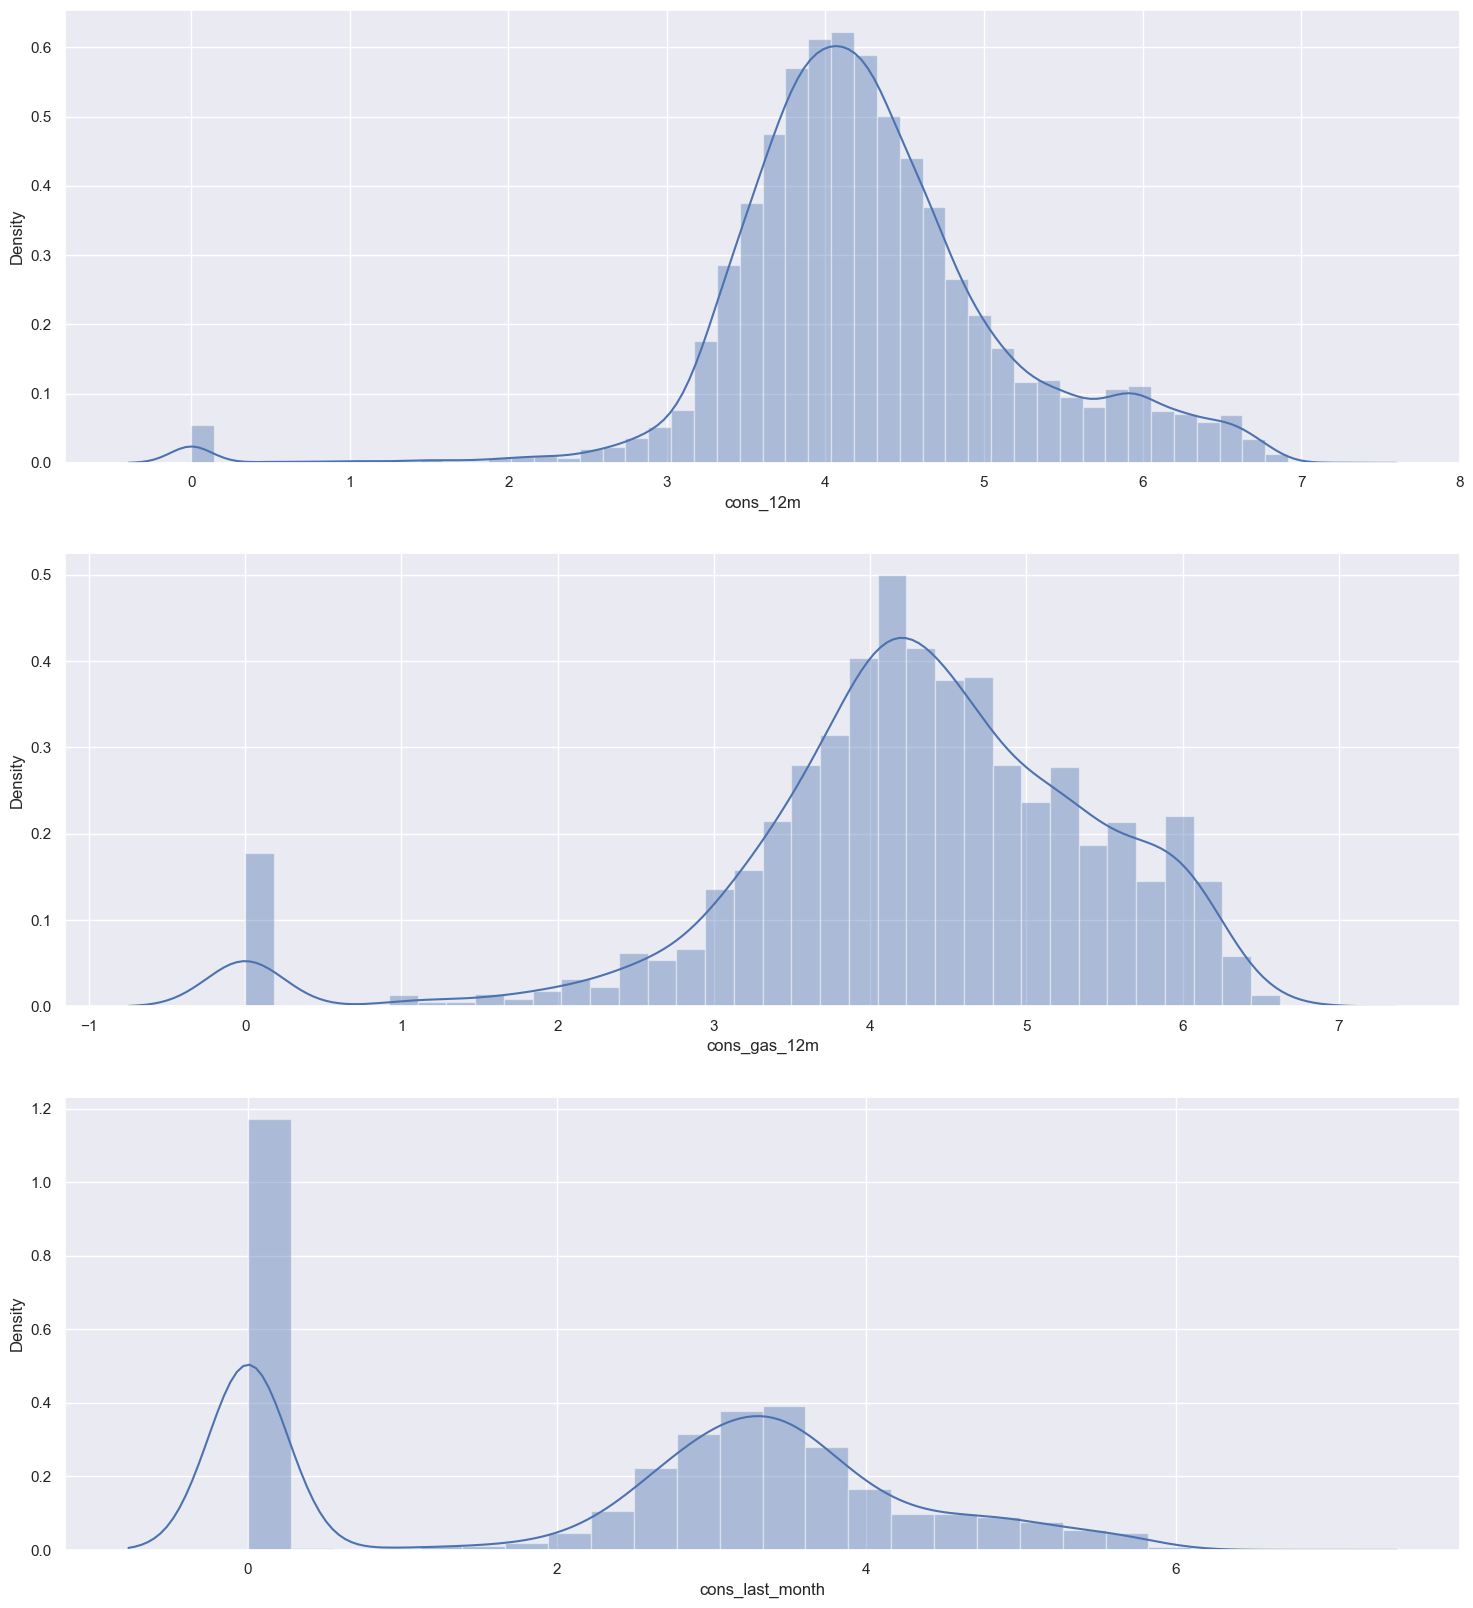

In [121]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((client_data["cons_12m"].dropna()), ax=axs[0])
sns.distplot((client_data[client_data["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((client_data["cons_last_month"].dropna()), ax=axs[2])
plt.show()

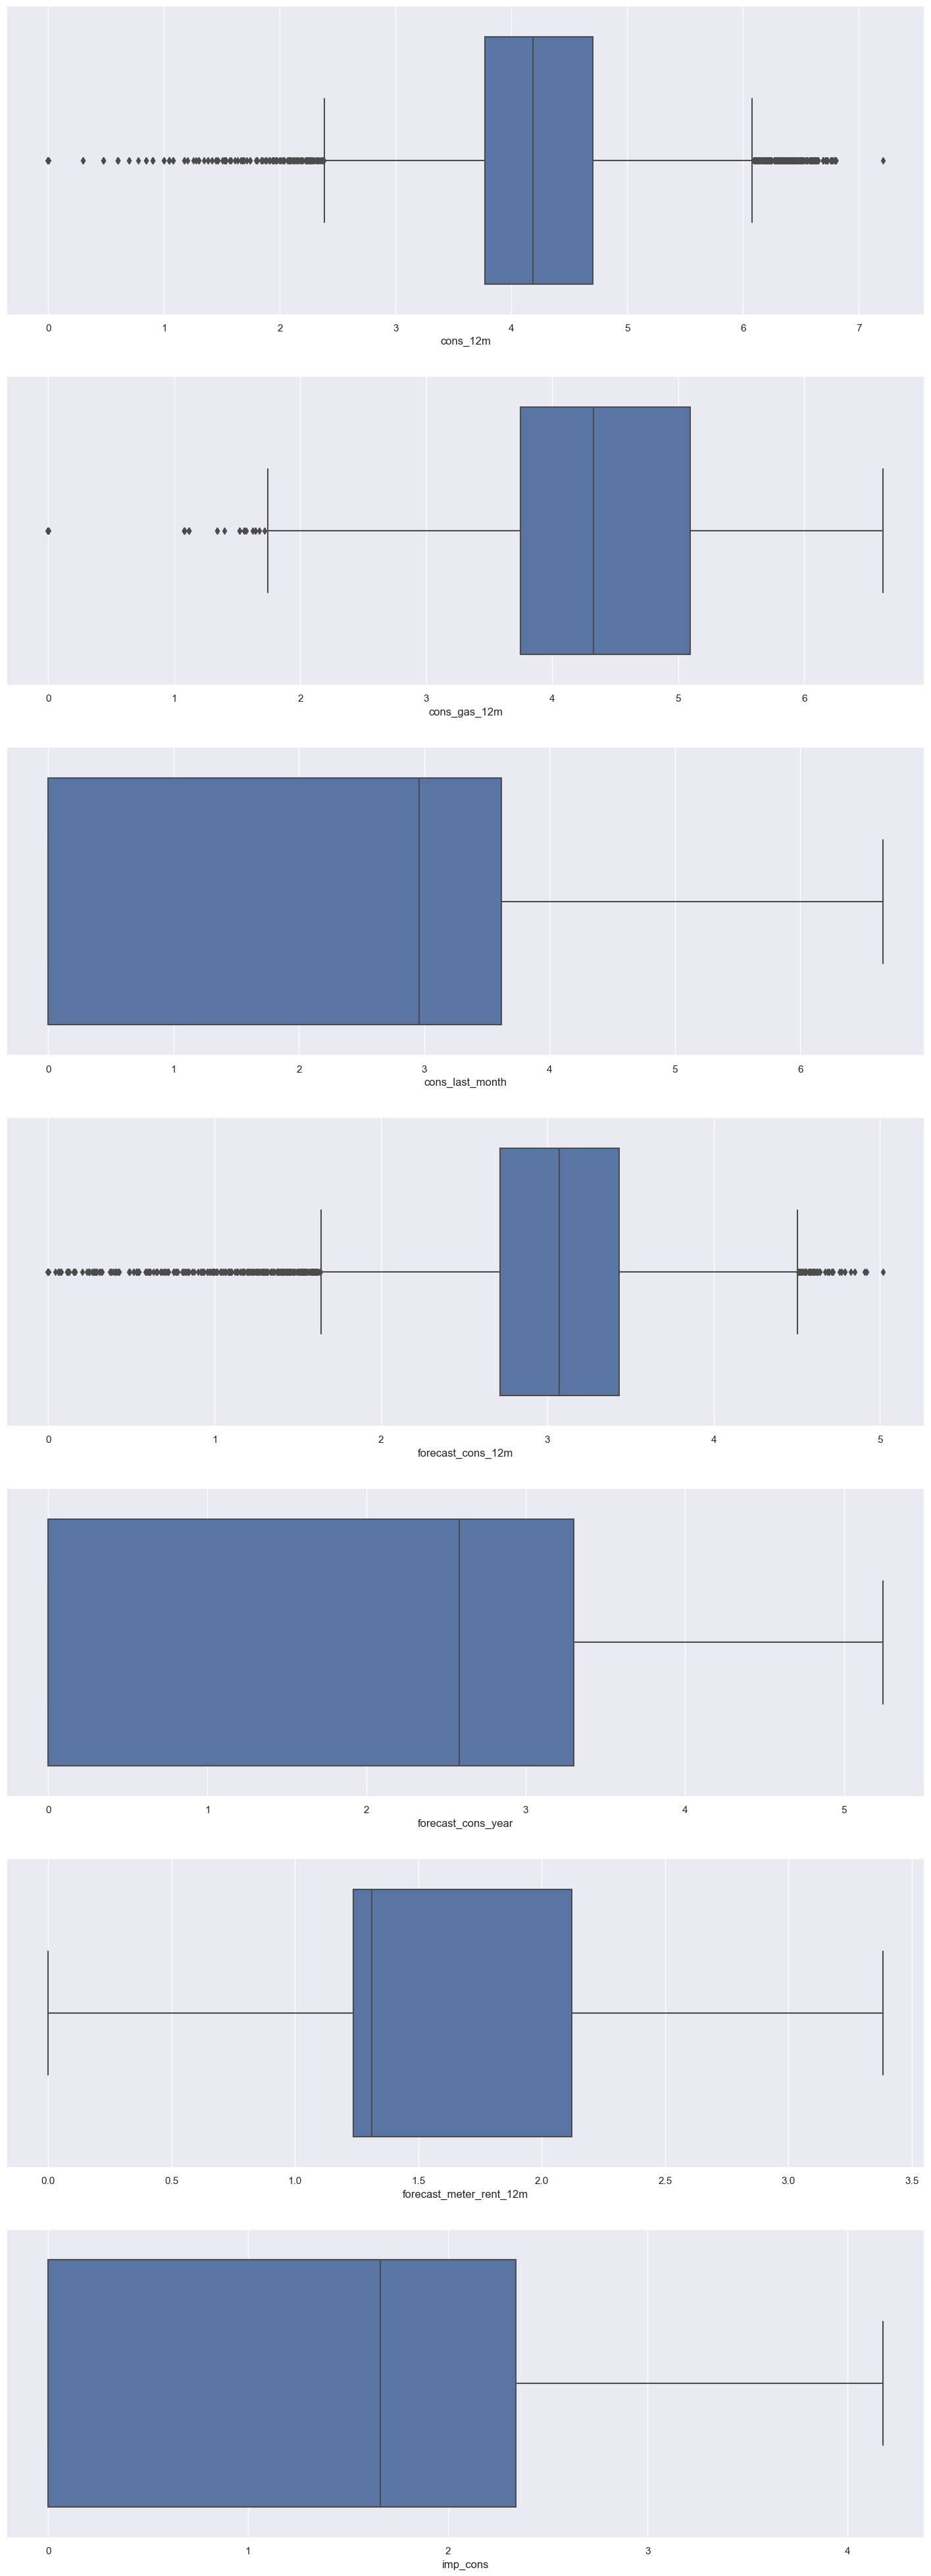

In [123]:
fig, axs = plt.subplots(nrows = 7, figsize = (18, 50));
# Plot Boxplot
sns.boxplot(x = client_data['cons_12m'].dropna(), ax = axs[0]);
sns.boxplot(x = client_data[client_data['has_gas'] == 1]['cons_gas_12m'].dropna(), ax = axs[1]);
sns.boxplot(x = client_data['cons_last_month'].dropna(), ax = axs[2]);
sns.boxplot(x = client_data['forecast_cons_12m'].dropna(), ax = axs[3]);
sns.boxplot(x = client_data['forecast_cons_year'].dropna(), ax = axs[4]);
sns.boxplot(x = client_data['forecast_meter_rent_12m'].dropna(), ax = axs[5]);
sns.boxplot(x = client_data['imp_cons'].dropna(), ax = axs[6]);
plt.show()

The distribution looks much closer to normal distributions now
Notice how the standard deviation std has changed

#### Correlations

In terms of creating new features and transforming existing ones, it is very much a trial and error situation that requires iteration. Once we train a predictive model we can see which features work and don't work, we will also know how predictive this set of features is. Based on this, we can come back to feature engineering to enhance our model.

For now, we will leave feature engineering at this point. Another thing that is always useful to look at is how correlated all of the features are within your dataset.

This is important because it reveals the linear relationships between features. We want features to correlate with churn, as this will indicate that they are good predictors of it. However features that have a very high correlation can sometimes be suspicious. This is because 2 columns that have high correlation indicates that they may share a lot of the same information. One of the assumptions of any parametric predictive model (as stated earlier) is that all features must be independent.

For features to be independent, this means that each feature must have absolutely no dependence on any other feature. If two features are highly correlated and share similar information, this breaks this assumption.

Ideally, you want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn). However, this is very rarely the case and it is common to have a small degree of correlation between independent features.

So now let's look at how all the features within the model are correlated.

In [127]:
client_data_copy = client_data.copy()


In [129]:
client_data = client_data.drop(columns= 'id')


In [131]:
correlation = client_data.corr()

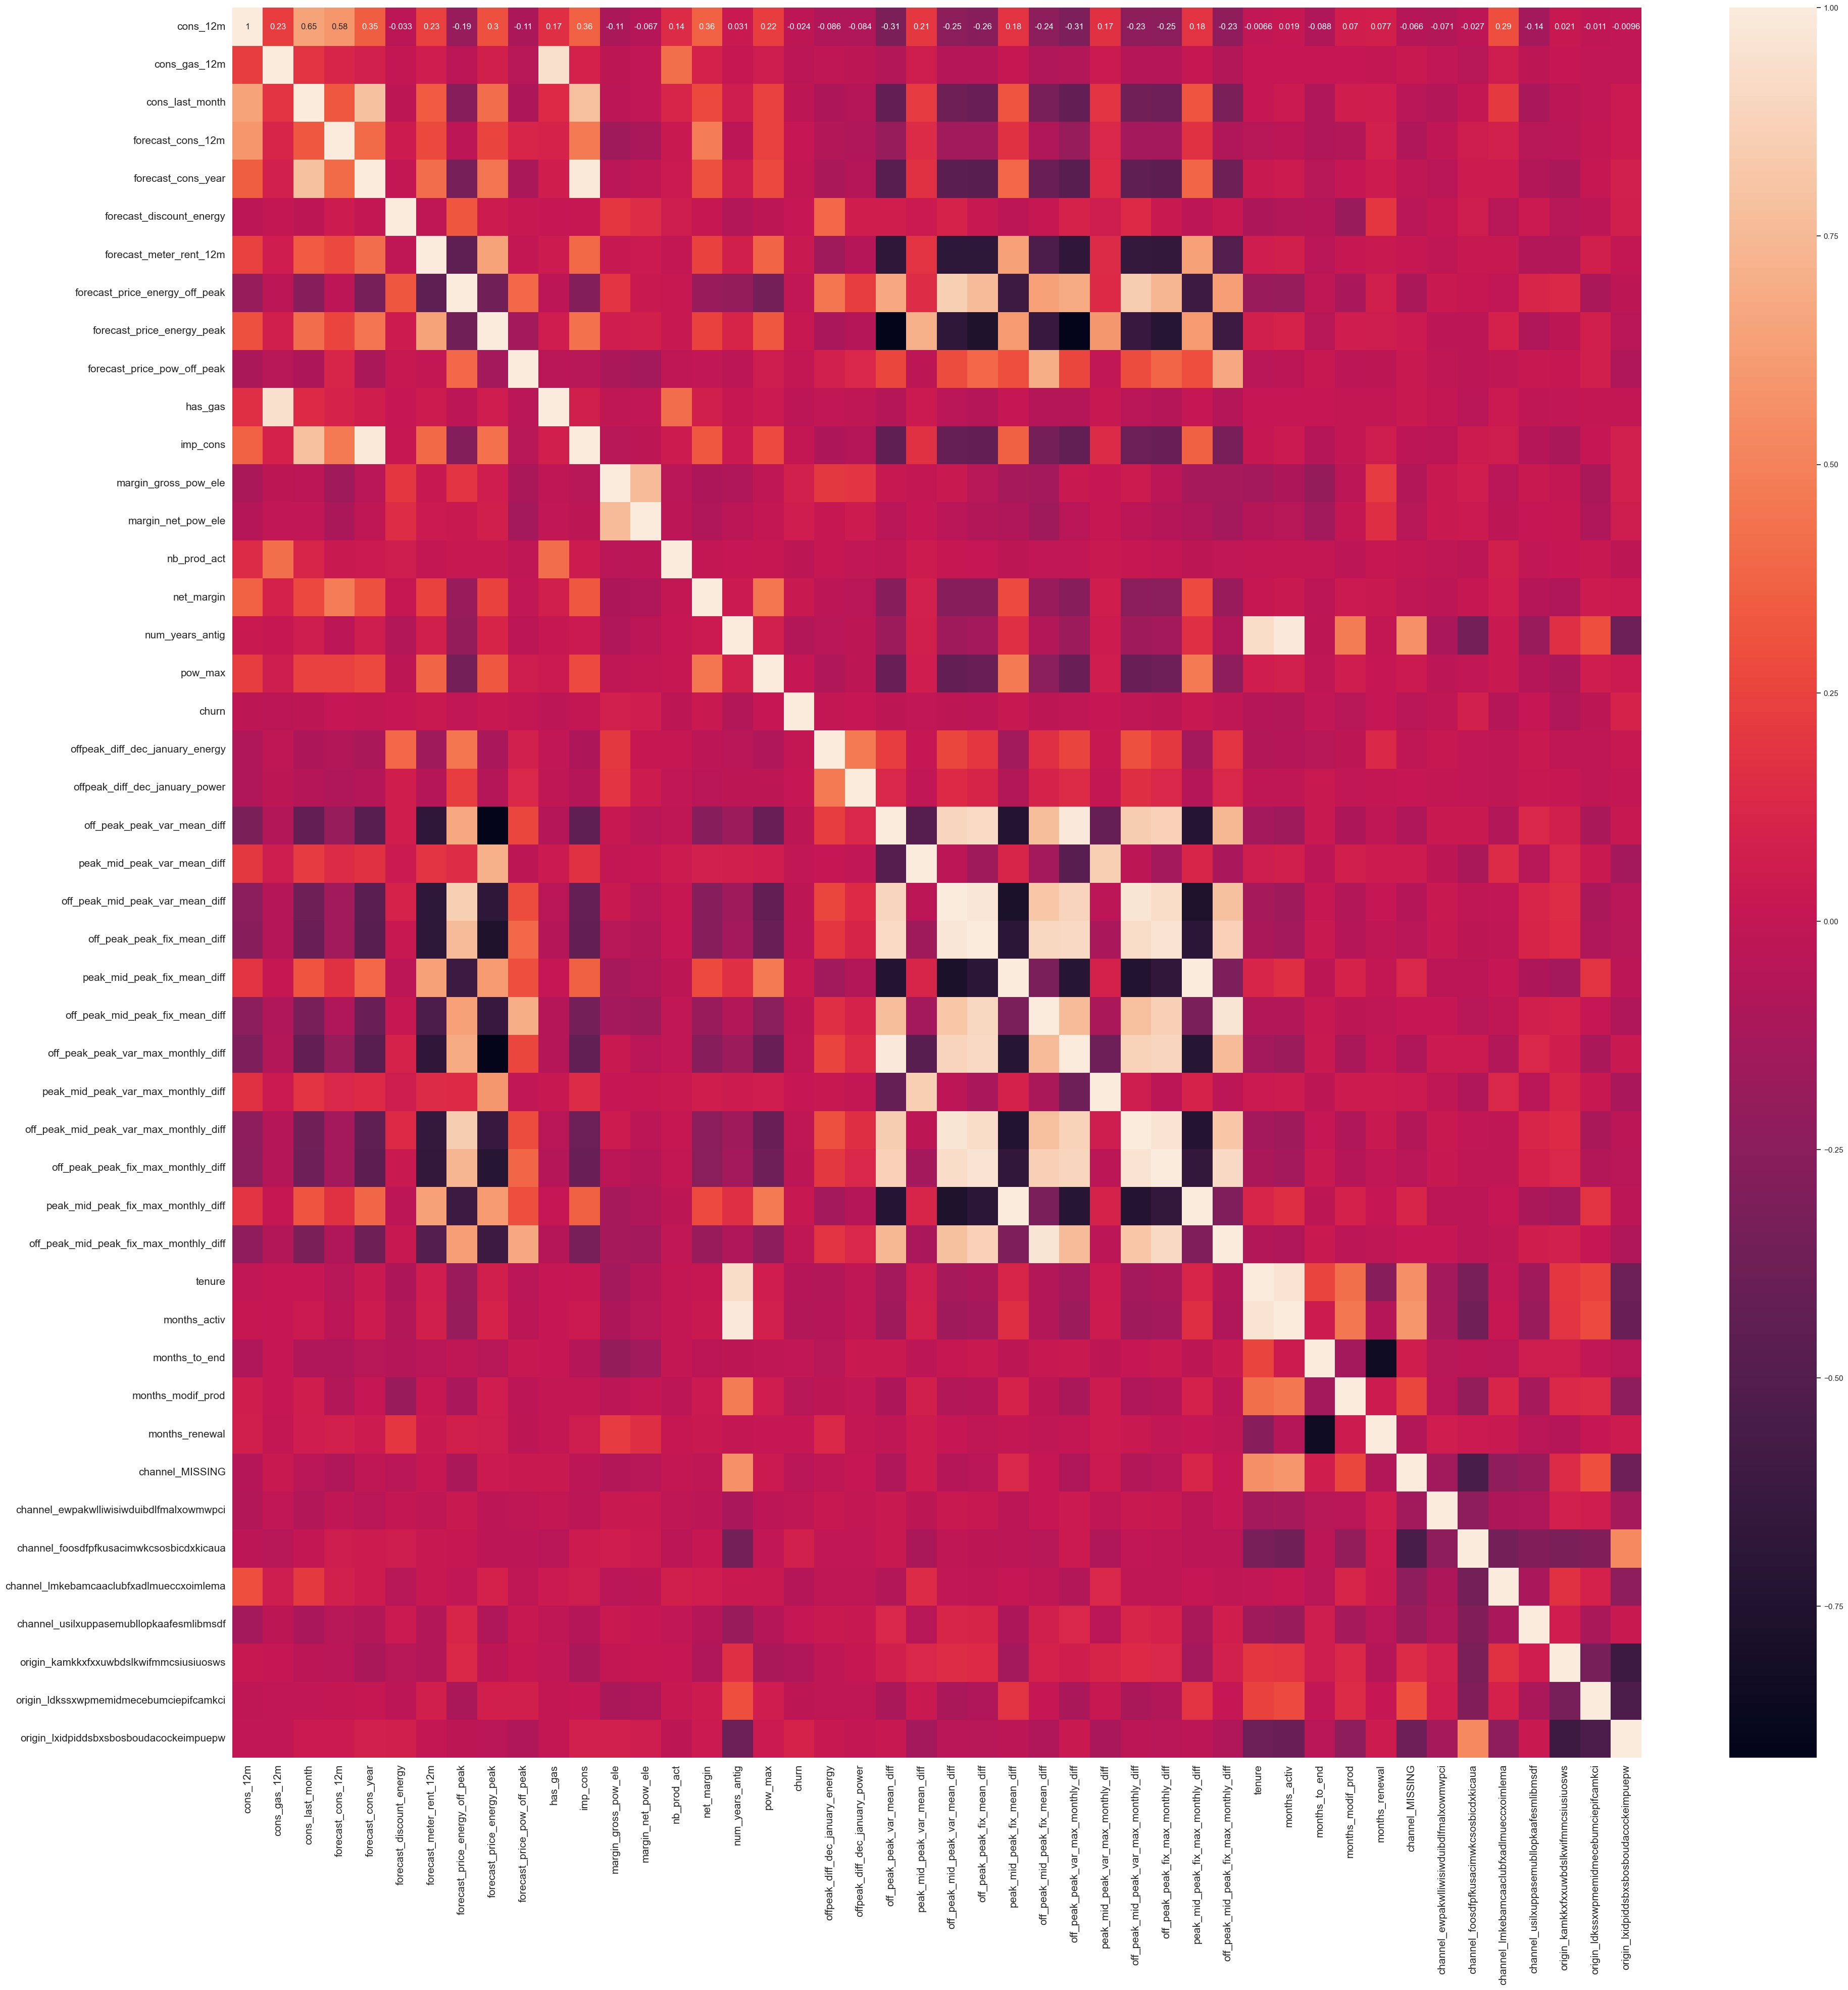

In [133]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

We decided to remove two variables which exhibit a high correlation with other independent features.

In [136]:
client_data = client_data.drop(columns=['num_years_antig', 'forecast_cons_year'])
client_data.head(2)

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw
0,5.490346,0.000000,4.001128,4.423595,0.0,2.556652,0.095919,0.088347,58.995952,0,2.920541,-41.76,-41.76,1,1732.36,180.000,0,-0.007952,0.236694,0.011334,0.024874,0.036208,22.599614,28.019836,50.619451,0.012569,0.026096,0.038665,22.682779,28.122958,50.805737,3,37,10,37,1,0,0,0,1,0,0,1,0
1,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,1,0.000000,25.44,25.44,2,678.99,43.648,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930,3,30,5,2,6,0,0,1,0,0,0,0,1


In [139]:
client_data.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw
0,5.490346,0.000000,4.001128,4.423595,0.0,2.556652,0.095919,0.088347,58.995952,0,2.920541,-41.76,-41.76,1,1732.36,180.000,0,-0.007952,0.236694,0.011334,0.024874,0.036208,22.599614,28.019836,50.619451,0.012569,0.026096,0.038665,22.682779,28.122958,50.805737,3,37,10,37,1,0,0,0,1,0,0,1,0
1,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,1,0.000000,25.44,25.44,2,678.99,43.648,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930,3,30,5,2,6,0,0,1,0,0,0,0,1
2,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,0,0.000000,16.38,16.38,1,18.89,13.800,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.444710,7,76,7,76,4,1,0,0,0,0,1,0,0
3,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,0,0.000000,28.60,28.60,1,6.60,13.856,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.444710,6,68,3,68,8,0,0,1,0,0,1,0,0
4,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,0,0.000000,30.22,30.22,1,25.46,13.200,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.444710,6,69,2,69,9,0,0,0,1,0,1,0,0


## Modelling

We're focusing on training a RANDOM CLASSIFIER 

In [142]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#### Data sampling
The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [145]:
#we want to seperate the result column(which is the dependent variable) from all 
#the other columns which are the independent variables(meaning these columns predict 
#the result or the dependent column)
#the purpose for all of these is cbecause we're trying to train the machine/model to predict the
#results hence we do not need the result column

#we start by assigning column 'churn' to a new variable called result

Result = client_data['churn']

In [147]:
client_data = client_data.drop(columns='churn')

In [149]:
#next we want to split the rmaining part of our dataset into 70:30 portion. 
#we will use 70% to train our model and then the rest 30% to compare when we're done #building our model

train_test_split(client_data, Result, test_size =0.3, random_state =41)

[       cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
 13780  6.241304      0.000000         5.025969           3.721624   
 2862   4.325351      4.174292         3.252853           3.331494   
 15216  3.973128      0.000000         2.826723           3.142637   
 7178   3.892929      0.000000         3.170262           3.068883   
 8412   2.978181      0.000000         1.623249           2.257054   
 ...         ...           ...              ...                ...   
 5200   3.379668      0.000000         2.346353           2.761116   
 4066   4.402605      0.000000         3.352954           3.081743   
 12172  4.294907      5.297815         3.623042           2.768638   
 931    5.154984      0.000000         4.009961           3.006154   
 1984   4.331852      4.720515         3.315760           3.339338   
 
        forecast_discount_energy  forecast_meter_rent_12m  \
 13780                       0.0                 2.125579   
 2862                        0.0    

In [151]:
#the split done in the line above will split the data into 04 parts
#(sample_data 70% and 30% then results 70% and 30% making it four parts)
#now we want to assign each of those parts to new variables
training_clientdata, test_clientdata, training_Result, test_Result= train_test_split(client_data, Result, test_size =0.3, random_state =41)

In [153]:
test_clientdata

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_ldkssxwpmemidmecebumciepifcamkci,origin_lxidpiddsbxsbosboudacockeimpuepw
166,3.768638,0.000000,0.000000,2.944951,0.0,1.252853,0.144902,0.000000,44.311378,0,0.000000,9.92,9.92,1,75.75,13.200,-0.004847,0.177779,0.149712,0.000000,0.149712,44.296560,0.000000,44.296560,0.151635,0.000000,0.151635,44.444710,0.000000,44.444710,7,74,9,74,2,0,0,0,1,0,0,0,1
3907,4.383313,3.838975,3.225051,3.546383,0.0,1.204934,0.142065,0.000000,44.311378,1,2.384783,19.28,19.28,2,270.68,10.392,-0.000488,0.177779,0.145552,0.000000,0.145552,44.400265,0.000000,44.400265,0.148405,0.000000,0.148405,44.444710,0.000000,44.444710,2,31,4,19,7,0,0,1,0,0,0,0,1
1094,4.566756,4.701430,3.476397,3.578409,0.0,2.123067,0.115237,0.100123,40.606701,1,2.478826,5.52,5.52,2,404.12,16.500,-0.009831,0.000000,0.020267,0.030291,0.050559,16.291555,8.145775,24.437330,0.022227,0.032069,0.054296,16.291555,8.145775,24.437330,7,74,9,7,2,1,0,0,0,0,1,0,0
10000,4.405927,0.000000,3.589167,3.574177,0.0,0.000000,0.143166,0.000000,44.311378,0,2.751333,12.98,12.98,1,264.77,15.000,-0.003778,0.177779,0.147137,0.000000,0.147137,44.311375,0.000000,44.311375,0.148825,0.000000,0.148825,44.444710,0.000000,44.444710,6,63,8,63,3,0,0,1,0,0,0,0,1
13728,6.093687,0.000000,5.093162,3.254652,0.0,2.123231,0.115174,0.098837,40.606701,0,2.352395,19.65,19.65,1,232.59,18.500,-0.007801,0.162916,0.020390,0.029112,0.049502,16.264402,8.132199,24.396601,0.022581,0.031859,0.054440,16.291555,8.145775,24.437330,6,78,4,78,7,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,4.108193,0.000000,0.000000,2.637650,0.0,1.237292,0.146694,0.000000,44.311378,0,0.000000,33.12,33.12,1,45.11,13.200,-0.005150,-0.000001,0.150643,0.000000,0.150643,44.266930,0.000000,44.266930,0.153133,0.000000,0.153133,44.266931,0.000000,44.266931,7,71,12,71,0,0,0,1,0,0,1,0,0
3759,4.340008,0.000000,3.439333,2.410963,24.0,1.286007,0.182936,0.000000,47.800878,0,1.609808,35.54,35.54,2,14.04,10.500,-0.006963,2.183779,0.189832,0.000000,0.189832,45.942912,0.000000,45.942912,0.191900,0.000000,0.191900,47.944710,0.000000,47.944710,3,35,11,12,0,0,0,1,0,0,0,0,1
1374,4.195761,0.000000,3.170848,3.179428,0.0,2.234897,0.114604,0.098262,40.606701,0,2.150173,38.12,38.12,1,171.58,41.600,-0.008381,0.162916,0.020465,0.029260,0.049725,16.258972,8.129484,24.388456,0.022581,0.031859,0.054440,16.291555,8.145775,24.437330,7,78,5,7,6,1,0,0,0,0,0,0,1
14355,5.094702,0.000000,3.716921,4.032374,0.0,2.550204,0.097701,0.089427,58.995952,0,2.646355,-8.72,-8.72,1,742.07,85.000,-0.007191,0.236694,0.011228,0.024444,0.035672,22.637417,28.066709,50.704126,0.012839,0.026178,0.039017,22.682779,28.122958,50.805737,4,42,5,42,6,0,0,0,1,0,0,1,0


In [155]:
random_model = RandomForestClassifier(max_depth =6, n_estimators = 1000)

In [157]:
random_model

RandomForestClassifier(max_depth=6, n_estimators=1000)

In [159]:
# Check for missing values in the DataFrame
missing_values = training_clientdata.isnull().sum()
print(missing_values[missing_values > 0])


cons_12m                   20
cons_gas_12m                4
cons_last_month            31
forecast_cons_12m          30
forecast_meter_rent_12m     3
imp_cons                   17
dtype: int64


In [161]:
training_clientdata = training_clientdata.dropna()
training_Result = training_Result[training_clientdata.index]  
# Ensure target aligns


In [163]:
random_model.fit(training_clientdata,training_Result)

RandomForestClassifier(max_depth=6, n_estimators=1000)

In [165]:
random_model.score(training_clientdata, training_Result)

0.9030010718113612

In [167]:
# Check for missing values in the DataFrame
missing_values = test_clientdata.isnull().sum()
print(missing_values[missing_values > 0])


cons_12m                    7
cons_gas_12m                2
cons_last_month            15
forecast_cons_12m          11
forecast_meter_rent_12m     1
imp_cons                   10
dtype: int64


In [169]:
test_clientdata = test_clientdata.dropna()
test_Result = test_Result[test_clientdata.index]  
# Ensure target aligns


In [171]:
random_model.score(test_clientdata, test_Result)

0.8985627994167882

In [173]:
#here we're giving our model(which has been trained) new data(our 30% data which we put aside)
#to analyse, predict (using .predict) and then compare to the actual results(test_results 
#which is the 30% of the results) to know how accurate our model is.
#then we assign our prediction to a variable
prediction= random_model.predict(test_clientdata)

In [175]:
results = {'actual':test_Result,
           'prediction':prediction
    
}

In [177]:
final_results = pd.DataFrame(results)

In [179]:
#putting our prediction and the actual results side by side to compare the accuracy

final_results[:50]

,actual,prediction
166,1,0
3907,0,0
1094,0,0
10000,0,0
13728,0,0
7071,0,0
265,0,0
63,0,0
3291,0,0
10312,0,0


In [181]:
from sklearn.metrics import confusion_matrix



confusion_matrix(test_Result, prediction)

array([[4314,    0],
       [ 487,    0]])

In [183]:
tn, fp, fn, tp = confusion_matrix(test_Result, prediction).ravel()

In [185]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {accuracy_score(test_Result, prediction)}")
print(f"Precision: {precision_score(test_Result, prediction)}")
print(f"Recall: {recall_score(test_Result, prediction)}")

True positives: 0
False positives: 0
True negatives: 4314
False negatives: 487

Accuracy: 0.8985627994167882
Precision: 0.0
Recall: 0.0


In [187]:
print(classification_report(test_Result,prediction))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4314
           1       0.00      0.00      0.00       487

    accuracy                           0.90      4801
   macro avg       0.45      0.50      0.47      4801
weighted avg       0.81      0.90      0.85      4801



### Interpretation of Results


This model exhibits several characteristics:

#### High Precision, Low positive predictions: 
The model exhibits impressive precision for both class 0 and class 1, indicating its reliability in making accurate positive predictions. However, the model also results an absence of true positive predictions (TP = o) and false positives (FP = 0). This suggests that the model may be conservative in labeling instances as positive. It's essential to assess whether this conservative nature aligns with the goal of identifying more positive cases.

#### Struggling to Detect Churn Cases: 
The model encounters challenges in recognizing class 1 instances, which represent customers at risk of churning. The model's recall for class 1 indicates that it overlooks a significant number of potential churn cases. This limitation raises concerns, especially as our primary objective is to accurately identify and address churn.

#### Accuracy May Be Misleading: 
The overall accuracy of the model is high at 89.85%. However, this high accuracy is primarily driven by the abundance of class 0 instances in the dataset. The model's inability to effectively identify class 1 instances is reflected in the low recall for class 1.

#### Consider Data Imbalance: 
The class imbalance, with a much larger number of class 0 instances than class 1 instances, can lead to our model favoring the majority class. In this case, the model's high precision for both classes suggests that it tends to make negative (class 0) predictions more often.

In summary, this model excels in terms of precision but suffers from a significant issue with recall for class 1. It has high accuracy primarily because imbalance in your dataset, where non-churning customers vastly outnumber churning ones. Addressing the low recall for class 1 will be essential for improving the model's performance.

### Hyperparameter tuning of Random Forest model using grid search and additional Cross Validation parameters 

Using cv_params allows us systematically explore various combinations of hyperparameters, helping us find the best configuration for your model.

In [195]:
#Our goal is to improve Recall (the proportion of True Positive predictions out of all actual positive instances in the dataset.)

In [198]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)

#n_estimators=500 specifies the number of trees in the forest
#random_state=42 ensures reproducibility.

cv_params2 = {
    'max_depth': [3, 5, 9],   #Limits the depth of the trees to prevent overfitting
    'min_samples_split': [5, 10, 13],  
    'min_samples_leaf': [2, 3, 5],
    'max_features': [0.6],
    'max_samples': [0.7],  # Proportion of samples to draw for training each tree
    'class_weight': ['balanced'],  # Class weights helpful in imbalanced datasets
}


scoring = {'precision', 'recall', 'accuracy', 'f1', 'roc_auc'}

rf_cv2 = GridSearchCV(rf, cv_params2, scoring=scoring, cv=5, refit='recall')

#cv=5 specifies 5-fold cross-validation, which means the training data will be split into 5 subsets for evaluation.
#refit='recall' indicates that after finding the best hyperparameters, the model will be refitted using the training data optimized for recall.


In [201]:
%%time

rf_cv2.fit(training_clientdata,training_Result)

CPU times: user 18min 7s, sys: 5.28 s, total: 18min 13s
Wall time: 18min 13s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=500,
                                              random_state=42),
             param_grid={'class_weight': ['balanced'], 'max_depth': [3, 5, 9],
                         'max_features': [0.6], 'max_samples': [0.7],
                         'min_samples_leaf': [2, 3, 5],
                         'min_samples_split': [5, 10, 13]},
             refit='recall',
             scoring={'roc_auc', 'accuracy', 'f1', 'recall', 'precision'})

In [203]:

# Retrieve the best hyperparameters
best_params = rf_cv2.best_params_

# Retrieve the best cross-validation score
best_score = rf_cv2.best_score_


In [205]:
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 0.6, 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 5}
Best Cross-Validation Score: 0.5179850336109584


In [207]:
rf_cv2.best_score_

0.5179850336109584

In [209]:
rf_cv2.best_params_

{'class_weight': 'balanced',
 'max_depth': 3,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [211]:

#evaluate the model on our test dataset to see how it performs in a real-world scenario
preds2 = rf_cv2.best_estimator_.predict((test_clientdata))

In [213]:
tn, fp, fn, tp = confusion_matrix(test_Result, preds2).ravel()

In [215]:
#using performance metrics to assess performance

tn, fp, fn, tp = confusion_matrix(test_Result, preds2).ravel()

print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {accuracy_score(test_Result, preds2)}")
print(f"Precision: {precision_score(test_Result, preds2)}")
print(f"Recall: {recall_score(test_Result, preds2)}")

True positives: 251
False positives: 1263
True negatives: 3051
False negatives: 236

Accuracy: 0.6877733805457197
Precision: 0.16578599735799207
Recall: 0.5154004106776181


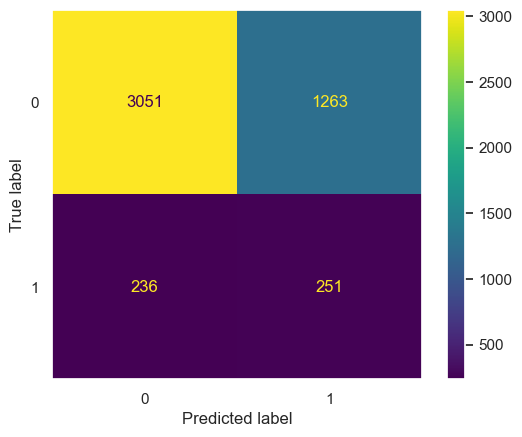

In [218]:

#display ConfusionMatrix
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(test_Result, preds2), display_labels=rf_cv2.classes_)

disp.plot()

plt.grid(None)

In [220]:
confusion_matrix(test_Result, preds2)

array([[3051, 1263],
       [ 236,  251]])

#### Breakdown of the Confusion Matrix
    True Positives (TP): 251
These are the instances where the model correctly predicted that a customer would churn.

    False Positives (FP): 1263
These are the instances where the model incorrectly predicted churn for customers who did not actually churn.

    False Negatives (FN): 236
These are the instances where the model failed to predict churn for customers who did churn.

    True Negatives (TN): 3051
These are the instances where the model correctly predicted that a customer would not churn.